In [1]:
# Φόρτωση Βιβλιοθηκών
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from numpy import log
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras import optimizers

import warnings
warnings.filterwarnings("ignore")

C:\Users\chris\anaconda4\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\chris\anaconda4\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\chris\anaconda4\lib\site-packages\numpy\.libs\libopenblas.xwydx2ikjw2nmtwsfyngfuwkqu3lytcz.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Διάβασμα δεδομένων
greece_inflation = pd.read_csv('Inflation and Parameters.csv', index_col=0)
greece_inflation.head()

,Cpi,Food Price Index,Energy Price Index,Hicp,Unemployment Rate,Gdp,Rent Price,House Prices,Lci
Date,,,,,,,,,
2001-01-01,0.001806,0.016060,0.111474,0.003837,0.109312,0.000000,0.000000,0.315560,0.000000
2001-02-01,0.000000,0.011688,0.097947,0.000000,0.110324,0.005330,0.006099,0.328415,0.017084
2001-03-01,0.036626,0.008565,0.077760,0.042722,0.110324,0.010660,0.012198,0.341270,0.034167
2001-04-01,0.054424,0.003301,0.082858,0.063443,0.118421,0.015991,0.018297,0.354126,0.051251
2001-05-01,0.062677,0.009190,0.087208,0.072909,0.117409,0.029163,0.025907,0.352209,0.054301


In [3]:
# με την συνάρτηση generate_sequences δημιουργούμε τα κατάλληλα sequences για την εκπαίδευση του μοντέλου
def generate_sequences(time_series, n_steps):
    sequence, output = list(), list()
    
    for i in range(len(time_series)):

        # n_steps είναι ο αριθμός των προηγούμενων μηνών που χρησιμοποιούμε ώστε
        # να προβλέψουμε τον επόμενο μήνα
        window_limit = i + n_steps

        # μόλις φτιάξουμε και το τελευταίο sequence, η συνάρτηση 
        # επιστρέφει το σύνολο των sequences
        if window_limit > len(time_series)-1:
            break

        # αποθηκεύομε κάθε sequence σε μια λίστα, οι οποίες αποτελούν το input του μοντέλου
        # Παράλληλα, αποθηκεύουμε το target value σε μια ξεχωριστ΄η λίστα
        input_features, output = time_series[i:window_limit], time_series[window_limit]

        sequence.append(input_features)
        output.append(output)

        
    return np.asarray(sequence).astype('float32'), np.asarray(output).astype('float32')

In [4]:
# κρατάμε μόνο τους δείκτες που θέλουμε να προβλέψουμε
cols = ['Cpi', 'Hicp']
greece_inflation_pred = greece_inflation.loc[:, greece_inflation.columns.intersection(cols)]
greece_inflation_pred = greece_inflation_pred.apply(pd.to_numeric, errors='coerce')
greece_inflation_pred = greece_inflation_pred.fillna(method='bfill')
greece_inflation_pred.head()

,Cpi,Hicp
Date,,
2001-01-01,0.001806,0.003837
2001-02-01,0.000000,0.000000
2001-03-01,0.036626,0.042722
2001-04-01,0.054424,0.063443
2001-05-01,0.062677,0.072909


In [5]:
# υλοποίηση του univariate LSTM
def uni_LSTM():
    
    preds = []
    tests = [] 
    n_steps = 5

    # διατρέχουμε τα δεδομένα μας ανά στήλη, ώστε να προβλέψουμε κάθε δείκτη
    for col in greece_inflation_pred.columns:
        
        # καλο΄ύμε την συνάρτηση generate_sequences ώστε να 
        # χτίσουμε τα sequences που θα διοχετευτούν στο μοντέλο
        window, output = generate_sequences(greece_inflation_pred[col], n_steps)

        # απαραίτητο reshape για την υλοποίηση του μοντέλου
        window = window.reshape((window.shape[0], window.shape[1], 1))

        # LSTM univariate μοντ΄έλο
        lstm_model = Sequential()
        lstm_model.add(LSTM(50, input_shape=(n_steps, 1), activation='relu'))
        lstm_model.add(Dense(30,activation='relu'))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(1,activation='relu'))
        optimizer = optimizers.RMSprop(lr=0.0001)
        lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

        # split των δεδομένων σε train και test
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        # fit του μοντέλου
        lstm_model.fit(train_X, train_y, epochs=1000, verbose=0)

        test_X = test_X.reshape((test_X.shape[0], n_steps, 1))

        # πρόβλεψη με βάση τα test δεδομένα
        pred = lstm_model.predict(test_X, verbose=0)
        
        # δημιουργία των λιστών actual και predicted values
        preds.append(pred)
        tests.append(test_y)

        # υπολογισμός των error metrics
        mse = mean_squared_error(test_y, pred)
        rmse = math.sqrt(mean_squared_error(test_y, pred))
        mae = mean_absolute_error(test_y, pred)
        mape = mean_absolute_percentage_error(test_y, pred)

        print("Univariate LSTM MSE for Parameter[" + str(col) + "]:" + str(mse))
        print("Univariate LSTM RMSE for Parameter[" + str(col) + "]:" + str(rmse))
        print("Univariate LSTM MAE for Parameter[" + str(col) + "]:" + str(mae))

        title = "Univariate LSTM for " + "[" + col +"]"

        # δημιουργία των διαγραμ΄΄ατων των actual και predicted δεδομένων
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='red')
        plt.show()
    return preds, tests

Univariate LSTM MSE for Parameter[Cpi]:0.0020876736
Univariate LSTM RMSE for Parameter[Cpi]:0.045691067376632664
Univariate LSTM MAE for Parameter[Cpi]:0.034769274


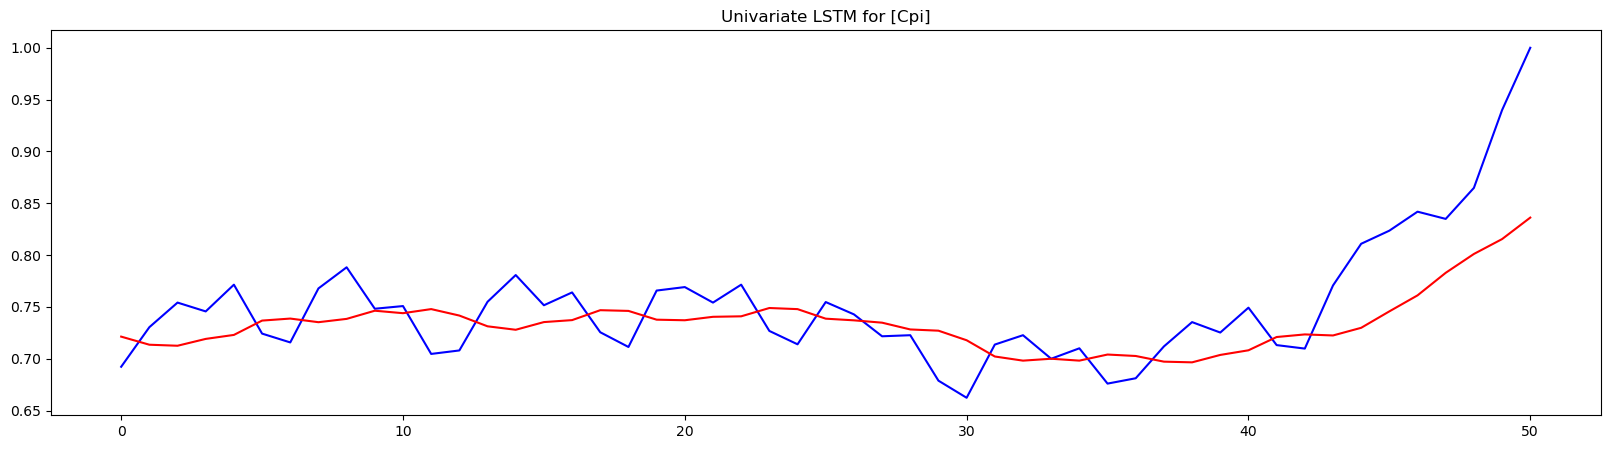

Univariate LSTM MSE for Parameter[Hicp]:0.0015870057
Univariate LSTM RMSE for Parameter[Hicp]:0.03983723988127538
Univariate LSTM MAE for Parameter[Hicp]:0.029627325


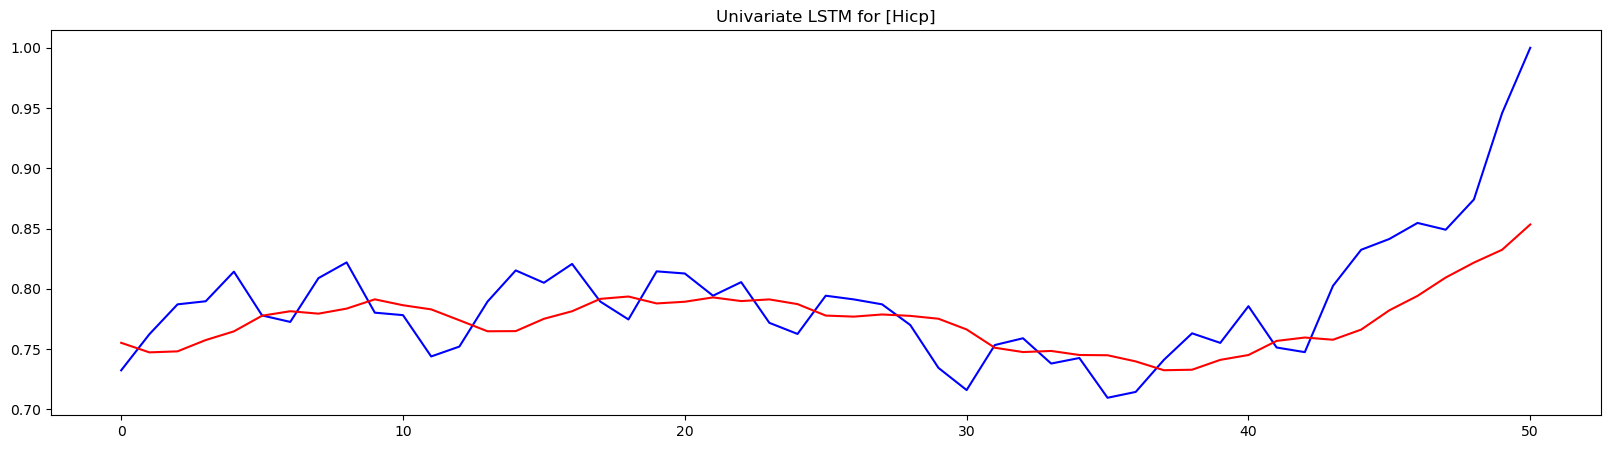

In [6]:
pred_ulstm,test_ulstm = uni_LSTM()